## Quality of unit isolation

**author**: steeve.laquitaine@epfl.ch

purpose: count proportions of single vs. multi-units +/- drift correction

## NOTES

- ks4 (+/-corr.)
    - M [DONE]
    - NS [DONE]
    - E [DONE]
- ks3 (+/-corr.)
    - M [RUNNING] ...
    - NS [RUNNING] ...
    - E [RUNNING] ...
- ks2_5 (+/-corr.)
    - M
    - NS
    - E
- ks2 (+/-corr.): drift is built-in and can't be disabled, so we skipped.

- NS-2X sortings were not backed up sor can't show it as reference


TROUBLESHOOTING:

- why NS results differ?
    - re-load and preprocess: high-pass filter [DONE] - NO
    - cast to float32 / int16 ? [DONE] - NO.
    - waveform extraction (sparse instead of from all sites): CAN'T TEST.
    - only site in cortex
    - all units in SortingExtractor are in cortex - OK
    - **curating sites outside cortex seem to solve this**

METHOD:

- 1. for sorting, select sites located in L1 to L6 (in ctx)
- 2. after sorting, select sorted units which estimated locations are in ctx (not outside) for analysis.

## Setup

Prerequisites:

- spike sort with pipelines in src/pipes/sorting/

Activate `spikebias`environment kernel

In [5]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import spikeinterface as si
from random import choices
from scipy import stats

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

# import custom package
#from src.nodes.utils import get_config
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# KS3
SORTED_ks3_paths = {
    "ms_v100_corr": './dataset/01_intermediate/sorting/marques/SortingKS3_10m',
    "ns_v100_corr": './dataset/01_intermediate/sorting/npx_spont/SortingKS3_10m',
    "ne_v100_corr": './dataset/01_intermediate/sorting/npx_evoked/SortingKS3_10m',
    "s_v100_corr": './dataset/01_intermediate/sorting/buccino/SortingKS3',
    "ds1_v100_corr": './dataset/01_intermediate/sorting/dense_probe1/SortingKS3_10m',
    "ms_rtx_corr": './temp/drift_correction/npx_vivo/SortingKS3_10m_RTX5090_DriftCorr',
    "ns_rtx_corr": './temp/drift_correction/npx_spont/SortingKS3_10m_RTX5090_DriftCorr',
    "ne_rtx_corr": './temp/drift_correction/npx_evoked_20khz/SortingKS3_10m_RTX5090_DriftCorr',
    "s_rtx_corr": './temp/drift_correction/npx_synth/SortingKS3_10m_RTX5090_DriftCorr',
    "ds1_rtx_corr": './temp/drift_correction/dense_spont_probe1/SortingKS3_10m_RTX5090_DriftCorr',
    "ms_rtx_no_corr": './temp/drift_correction/npx_vivo/SortingKS3_10m_RTX5090_NoDriftCorr',
    "ns_rtx_no_corr": './temp/drift_correction/npx_spont/SortingKS3_10m_RTX5090_NoDriftCorr',
    "ne_rtx_no_corr": './temp/drift_correction/npx_evoked_20khz/SortingKS3_10m_RTX5090_NoDriftCorr',
    "s_rtx_no_corr": './temp/drift_correction/npx_synth/SortingKS3_10m_RTX5090_NoDriftCorr',
    "ds1_rtx_no_corr": './temp/drift_correction/dense_spont_probe1/SortingKS3_10m_RTX5090_NoDriftCorr'
}

# KS4
SORTED_ks4_paths = {
    "ms_v100_corr": './dataset/01_intermediate/sorting/marques/SortingKS4_10m',
    "ns_v100_corr": './dataset/01_intermediate/sorting/npx_spont/SortingKS4_10m',
    "ne_v100_corr": './dataset/01_intermediate/sorting/npx_evoked/SortingKS4_10m',
    "s_v100_corr": './dataset/01_intermediate/sorting/buccino/SortingKS4',
    "ds1_v100_corr": './dataset/01_intermediate/sorting/dense_probe1/SortingKS4_10m',
    "ms_rtx_corr": './temp/drift_correction/npx_vivo/SortingKS4_10m_RTX5090_DriftCorr',
    "ns_rtx_corr": './temp/drift_correction/npx_spont/SortingKS4_10m_RTX5090_DriftCorr',
    "ne_rtx_corr": './temp/drift_correction/npx_evoked_20khz/SortingKS4_10m_RTX5090_DriftCorr',
    "s_rtx_corr": './temp/drift_correction/npx_synth/SortingKS4_10m_RTX5090_DriftCorr',
    "ds1_rtx_corr": './temp/drift_correction/dense_spont_probe1/SortingKS4_10m_RTX5090_DriftCorr',
    "ms_rtx_no_corr": './temp/drift_correction/npx_vivo/SortingKS4_10m_RTX5090_NoDriftCorr',
    "ns_rtx_no_corr": './temp/drift_correction/npx_spont/SortingKS4_10m_RTX5090_NoDriftCorr',
    "ne_rtx_no_corr": './temp/drift_correction/npx_evoked_20khz/SortingKS4_10m_RTX5090_NoDriftCorr',
    "s_rtx_no_corr": './temp/drift_correction/npx_synth/SortingKS4_10m_RTX5090_NoDriftCorr',
    "ds1_rtx_no_corr": './temp/drift_correction/dense_spont_probe1/SortingKS4_10m_RTX5090_NoDriftCorr'
}

# KS2_5
SORTED_ks2_5_paths = {
    "ms_v100_corr": './dataset/01_intermediate/sorting/marques/SortingKS2_5_10m',
    "ns_v100_corr": './dataset/01_intermediate/sorting/npx_spont/SortingKS2_5_10m',
    "ne_v100_corr": './dataset/01_intermediate/sorting/npx_evoked/SortingKS2_5_10m',
    "s_v100_corr": './dataset/01_intermediate/sorting/buccino/SortingKS2_5',
    "ds1_v100_corr": './dataset/01_intermediate/sorting/dense_probe1/SortingKS2_5_10m',
    "ms_rtx_corr": './temp/drift_correction/npx_vivo/SortingKS2_5_10m_RTX5090_DriftCorr',
    "ns_rtx_corr": './temp/drift_correction/npx_spont/SortingKS2_5_10m_RTX5090_DriftCorr',
    "ne_rtx_corr": './temp/drift_correction/npx_evoked_20khz/SortingKS2_5_10m_RTX5090_DriftCorr',
    "s_rtx_corr": './temp/drift_correction/npx_synth/SortingKS2_5_10m_RTX5090_DriftCorr',
    "ds1_rtx_corr": './temp/drift_correction/dense_spont_probe1/SortingKS2_5_10m_RTX5090_DriftCorr',
    "ms_rtx_no_corr": './temp/drift_correction/npx_vivo/SortingKS2_5_10m_RTX5090_NoDriftCorr',
    "ns_rtx_no_corr": './temp/drift_correction/npx_spont/SortingKS2_5_10m_RTX5090_NoDriftCorr',
    "ne_rtx_no_corr": './temp/drift_correction/npx_evoked_20khz/SortingKS2_5_10m_RTX5090_NoDriftCorr',
    "s_rtx_no_corr": './temp/drift_correction/npx_synth/SortingKS2_5_10m_RTX5090_NoDriftCorr',
    "ds1_rtx_no_corr": './temp/drift_correction/dense_spont_probe1/SortingKS2_5_10m_RTX5090_NoDriftCorr'
}

# EXPERIMENTS

# # Horvath (vivo)
# cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
# PRE_HV1 = cfg_hv1["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HV1 = cfg_hv1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
# PRE_HV2 = cfg_hv2["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HV2 = cfg_hv2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
# PRE_HV3 = cfg_hv3["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HV3 = cfg_hv3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# # Biophy spont.
# cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
# PRE_HS1 = cfg_hs1["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HS1 = cfg_hs1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
# PRE_HS2 = cfg_hs2["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HS2 = cfg_hs2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
# PRE_HS3 = cfg_hs3["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HS3 = cfg_hs3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# SETUP WAVEFORMS
MS_BEFORE = 3
MS_AFTER = 3

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -3.0
log_x_max = 3.0
nbins = 30

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Custom functions

In [6]:
def process_sorting_data(SORTED_ms_v100_corr, SORTED_ns_v100_corr, SORTED_ne_v100_corr,  SORTED_s_v100_corr, 
                         SORTED_ms_rtx_corr, SORTED_ns_rtx_corr, SORTED_ne_rtx_corr, SORTED_s_rtx_corr, 
                         SORTED_ms_rtx_no_corr, SORTED_ns_rtx_no_corr, SORTED_ne_rtx_no_corr, SORTED_s_rtx_no_corr):
    """
    Process sorting data by retrieving, filtering, and standardizing unit data.
    Keep units in L1 to L6 (in cortex)

    Returns:
        dict: A dictionary containing processed DataFrames for sorting data.
    """
    # get unit data
    sorting_data = {
        "ms_v100_corr": fr.get_sorted_unit_meta(SORTED_ms_v100_corr),
        "ns_v100_corr": fr.get_sorted_unit_meta(SORTED_ns_v100_corr),
        "ne_v100_corr": fr.get_sorted_unit_meta(SORTED_ne_v100_corr),
        "s_v100_corr": fr.get_sorted_unit_meta(SORTED_s_v100_corr),
        "ms_rtx_corr": fr.get_sorted_unit_meta(SORTED_ms_rtx_corr),
        "ns_rtx_corr": fr.get_sorted_unit_meta(SORTED_ns_rtx_corr),
        "ne_rtx_corr": fr.get_sorted_unit_meta(SORTED_ne_rtx_corr),
        "s_rtx_corr": fr.get_sorted_unit_meta(SORTED_s_rtx_corr),
        "ms_rtx_no_corr": fr.get_sorted_unit_meta(SORTED_ms_rtx_no_corr),
        "ns_rtx_no_corr": fr.get_sorted_unit_meta(SORTED_ns_rtx_no_corr),
        "ne_rtx_no_corr": fr.get_sorted_unit_meta(SORTED_ne_rtx_no_corr),
        "s_rtx_no_corr": fr.get_sorted_unit_meta(SORTED_s_rtx_no_corr),
    }

    # all units from Buccino model were from layer 5
    sorting_data['s_v100_corr'].layer='L5'
    sorting_data['s_rtx_corr'].layer='L5'
    sorting_data['s_rtx_no_corr'].layer='L5'

    # standardize layer 2/3
    for key in sorting_data:
        sorting_data[key]["layer"][
            (sorting_data[key]["layer"] == "L2") | (sorting_data[key]["layer"] == "L3") | (sorting_data[key]["layer"] == "L2_3")
        ] = "L2/3"

    # keep units in cortex
    for key in sorting_data:
        sorting_data[key] = sorting_data[key][
            np.isin(sorting_data[key]["layer"], ["L1", "L2", "L2/3", "L4", "L5", "L6"])
        ]
    return sorting_data


def process_each_experiment(exp, SORTED_ms_v100_corr, SORTED_ms_rtx_corr, SORTED_ms_rtx_no_corr):
    """
    Process sorting data by retrieving, filtering, and standardizing unit data.
    Keep units in L1 to L6 (in cortex)

    Returns:
        dict: A dictionary containing processed DataFrames for sorting data.
    """
    # get unit data
    sorting_data = {
        f"{exp}_v100_corr": fr.get_sorted_unit_meta(SORTED_ms_v100_corr),
        f"{exp}_rtx_corr": fr.get_sorted_unit_meta(SORTED_ms_rtx_corr),
        f"{exp}_rtx_no_corr": fr.get_sorted_unit_meta(SORTED_ms_rtx_no_corr),
    }

    # standardize layer 2/3
    for key in sorting_data:
        sorting_data[key]["layer"][
            (sorting_data[key]["layer"] == "L2") | (sorting_data[key]["layer"] == "L3") | (sorting_data[key]["layer"] == "L2_3")
        ] = "L2/3"

    # keep units in cortex
    for key in sorting_data:
        sorting_data[key] = sorting_data[key][
            np.isin(sorting_data[key]["layer"], ["L1", "L2", "L2/3", "L4", "L5", "L6"])
        ]
    return sorting_data

## Testing parameters

Big -> wrong site mapping to units - more should be outside cortex

In [4]:
# import spikeinterface.core.template_tools as ttools
# We = si.WaveformExtractor.load_from_folder('temp/npx_spont/study_ks4_10m_RTX5090_DriftCorr/')
# max_chids = ttools.get_template_extremum_channel(We, peak_sign="both")
# Wired = si.load_extractor('dataset/01_intermediate/preprocessing/recording_npx_spont') 
# Sorting = si.load_extractor('temp/npx_spont/SortingKS4_10m_RTX5090_DriftCorr/')

# unit_sites = pd.DataFrame.from_dict(max_chids, orient="index")
# unit_sites.columns = ["site"]
# site_layers = pd.DataFrame(
#     Wired.get_property("layers"), index=Wired.channel_ids, columns=["layer"]
# )

# # map sorted units to sites and layers
# # site_and_layer (index: site, columns: layer and unit)
# unit_sites = pd.DataFrame.from_dict(max_chids, orient="index", columns=["site"])
# unit_sites["unit"] = unit_sites.index
# unit_sites.index = unit_sites["site"].values
# unit_sites = unit_sites.drop(columns=["site"])
# site_and_layer = pd.merge(site_layers, unit_sites, left_index=True, right_index=True)
# site_and_layer = site_and_layer.sort_values(by="unit")

# # standardize layer names
# site_and_layer["layer"] = site_and_layer["layer"].replace(
#     "Outsideofthecortex", "Outside"
# )

# # Write metadata to Sorting Extractor
# print('layer', site_and_layer["layer"].tolist())
# print('contact', site_and_layer.index.tolist())

# print(sum(site_and_layer["layer"]=='Outside'))

# # Check waveforms
# unit = 1

# wv = We.get_waveforms(unit_id=We.unit_ids[unit])
# print(wv.shape)

# print(max_chids)

# # get its nearest channel
# c_ids = We.sparsity.unit_id_to_channel_ids[We.unit_ids[unit]]
# max_chid = max_chids[We.unit_ids[unit]]
# max_chid_ix = np.where(c_ids == max_chid)[0][0]
# print(max_chid, np.array(Wired.get_property('layers'))[int(max_chid)])
# plt.plot(wv[:,:,max_chid_ix].mean(axis=0))

# print(site_and_layer.sort_index())

## Get metadata

In [7]:
# get the unit proportions
ks3 = process_sorting_data(SORTED_ks3_paths["ms_v100_corr"], SORTED_ks3_paths["ns_v100_corr"], SORTED_ks3_paths["ne_v100_corr"], SORTED_ks3_paths["s_v100_corr"],
                           SORTED_ks3_paths["ms_rtx_corr"], SORTED_ks3_paths["ns_rtx_corr"], SORTED_ks3_paths["ne_rtx_corr"], SORTED_ks3_paths["s_rtx_corr"], 
                           SORTED_ks3_paths["ms_rtx_no_corr"], SORTED_ks3_paths["ns_rtx_no_corr"], SORTED_ks3_paths["ne_rtx_no_corr"], SORTED_ks3_paths["s_rtx_no_corr"])

ks4 = process_sorting_data(SORTED_ks4_paths["ms_v100_corr"], SORTED_ks4_paths["ns_v100_corr"], SORTED_ks4_paths["ne_v100_corr"], SORTED_ks4_paths["s_v100_corr"], 
                           SORTED_ks4_paths["ms_rtx_corr"], SORTED_ks4_paths["ns_rtx_corr"], SORTED_ks4_paths["ne_rtx_corr"], SORTED_ks4_paths["s_rtx_corr"], 
                           SORTED_ks4_paths["ms_rtx_no_corr"], SORTED_ks4_paths["ns_rtx_no_corr"], SORTED_ks4_paths["ne_rtx_no_corr"], SORTED_ks4_paths["s_rtx_no_corr"])

ks2_5 = process_sorting_data(SORTED_ks2_5_paths["ms_v100_corr"], SORTED_ks2_5_paths["ns_v100_corr"], SORTED_ks2_5_paths["ne_v100_corr"], SORTED_ks2_5_paths["s_v100_corr"], 
                             SORTED_ks2_5_paths["ms_rtx_corr"], SORTED_ks2_5_paths["ns_rtx_corr"], SORTED_ks2_5_paths["ne_rtx_corr"], SORTED_ks2_5_paths["s_rtx_corr"], 
                             SORTED_ks2_5_paths["ms_rtx_no_corr"], SORTED_ks2_5_paths["ns_rtx_no_corr"], SORTED_ks2_5_paths["ne_rtx_no_corr"], SORTED_ks2_5_paths["s_rtx_no_corr"])

# Unit-test: check all layers in cortex for ks3
for key in ks3:
    assert all(
        np.isin(np.sort(ks3[key]["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
    ), f"Not all layers in cortex for ks3[{key}]"

# Unit-test: check all layers in cortex for ks4
for key in ks4:
    assert all(
        np.isin(np.sort(ks4[key]["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
    ), f"Not all layers in cortex for ks4[{key}]"

# Unit-test: check all layers in cortex for ks4
for key in ks2_5:
    assert all(
        np.isin(np.sort(ks2_5[key]["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
    ), f"Not all layers in cortex for ks4[{key}]"

## Plot isolation quality NPX

In [8]:
ks3["s_rtx_no_corr"]

,layer,firing_rate,kslabel,amplitude
0,L5,3.7816667556762695,good,2637.4
1,L5,1.3633333444595337,good,1439.2
2,L5,4.864999771118164,good,1299.5
3,L5,4.073333263397217,good,1332.0
4,L5,0.1899999976158142,mua,708.4
...,...,...,...,...
574,L5,0.22333332896232605,mua,728.9
575,L5,4.539999961853027,good,1364.9
576,L5,6.916666507720947,good,1769.6
577,L5,11.901666641235352,good,1708.5


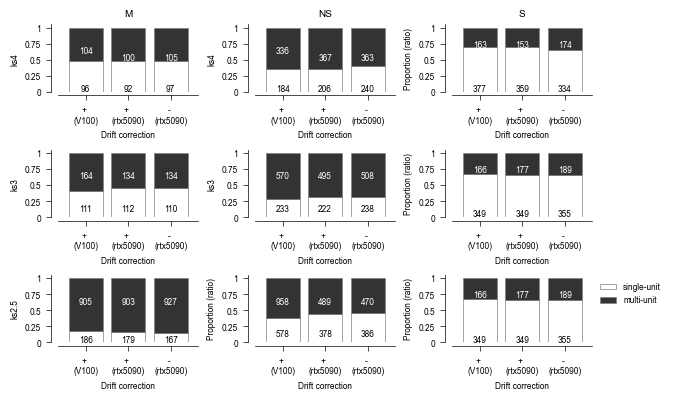

In [31]:
# setup
SHIFT = 0.3
_, ax = plt.subplots(3, 3, figsize=(6,4))

# KILOSORT 4 --------------

# MS
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.01, 'exp1_y_mu': 0.6, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.01, 'exp2_y_mu': 0.5, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.01, 'exp3_y_mu': 0.5}
isolation.plot_unit_isolation_by_drift_corr(ax[0, 0], ks4["ms_v100_corr"], ks4["ms_rtx_corr"], ks4["ms_rtx_no_corr"], legend_cfg, number_pos)
ax[0, 0].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax[0, 0].set_title('M')
ax[0, 0].set_ylabel('ks4')

# NS
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.01, 'exp1_y_mu': 0.6, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.01, 'exp2_y_mu': 0.5, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.01, 'exp3_y_mu': 0.5}
isolation.plot_unit_isolation_by_drift_corr(ax[0, 1], ks4["ns_v100_corr"], ks4["ns_rtx_corr"], ks4["ns_rtx_no_corr"], legend_cfg, number_pos)
ax[0, 1].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax[0, 1].set_title('NS')
ax[0, 1].set_ylabel('ks4')

# S
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.01, 'exp1_y_mu': 0.7, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.01, 'exp2_y_mu': 0.7, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.01, 'exp3_y_mu': 0.7}
isolation.plot_unit_isolation_by_drift_corr(ax[0,2], ks4["s_v100_corr"], ks4["s_rtx_corr"], ks4["s_rtx_no_corr"], legend_cfg, number_pos)
ax[0, 2].set_title('S')
ax[0, 2].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])


# KILOSORT 3 --------------

# MS
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.1, 'exp1_y_mu': 0.6, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.1, 'exp2_y_mu': 0.6, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.1, 'exp3_y_mu': 0.6}
isolation.plot_unit_isolation_by_drift_corr(ax[1, 0], ks3["ms_v100_corr"], ks3["ms_rtx_corr"], ks3["ms_rtx_no_corr"], legend_cfg, number_pos)
ax[1, 0].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax[1, 0].set_ylabel('ks3')

# NS
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.1, 'exp1_y_mu': 0.6, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.1, 'exp2_y_mu': 0.6, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.1, 'exp3_y_mu': 0.6}
isolation.plot_unit_isolation_by_drift_corr(ax[1, 1], ks3["ns_v100_corr"], ks3["ns_rtx_corr"], ks3["ns_rtx_no_corr"], legend_cfg, number_pos)
ax[1, 1].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax[1, 1].set_ylabel('ks3')

# S
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.01, 'exp1_y_mu': 0.7, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.01, 'exp2_y_mu': 0.7, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.01, 'exp3_y_mu': 0.7}
isolation.plot_unit_isolation_by_drift_corr(ax[1,2], ks3["s_v100_corr"], ks3["s_rtx_corr"], ks3["s_rtx_no_corr"], legend_cfg, number_pos)
ax[1,2].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])


# # KILOSORT 2.5 --------------

# MS
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.01, 'exp1_y_mu': 0.6, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.01, 'exp2_y_mu': 0.6, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.01, 'exp3_y_mu': 0.6}
isolation.plot_unit_isolation_by_drift_corr(ax[2, 0], ks2_5["ms_v100_corr"], ks2_5["ms_rtx_corr"], ks2_5["ms_rtx_no_corr"], legend_cfg, number_pos)
ax[2, 0].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax[2, 0].set_ylabel('ks2.5')

# NS
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.1, 'exp1_y_mu': 0.6, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.1, 'exp2_y_mu': 0.6, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.1, 'exp3_y_mu': 0.6}
isolation.plot_unit_isolation_by_drift_corr(ax[2, 1], ks2_5["ns_v100_corr"], ks2_5["ns_rtx_corr"], ks2_5["ns_rtx_no_corr"], legend_cfg, number_pos)
ax[2, 1].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

# S
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.01, 'exp1_y_mu': 0.7, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.01, 'exp2_y_mu': 0.7, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.01, 'exp3_y_mu': 0.7}
isolation.plot_unit_isolation_by_drift_corr(ax[2,2], ks3["s_v100_corr"], ks3["s_rtx_corr"], ks3["s_rtx_no_corr"], legend_cfg, number_pos)
ax[2,2].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()

# legend
plt.legend(['single-unit', 'multi-unit'], frameon=False, bbox_to_anchor=(1, 1), loc="upper left")

# save figures
plt.savefig("figures/7_reviews/figxx_no_drift_corr.svg", **savefig_cfg, bbox_inches="tight")
plt.savefig("figures/7_reviews/figxx_no_drift_corr.pdf", **savefig_cfg, bbox_inches="tight")

### For a single recording

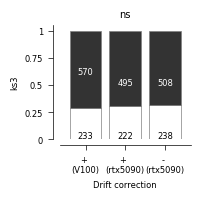

In [8]:
# parameters
exp = 'ns'
sorter = 'ks3'

# compute data
plot_data = process_each_experiment(exp, SORTED_ks3_paths[f"{exp}_v100_corr"], SORTED_ks3_paths[f"{exp}_rtx_corr"], SORTED_ks3_paths[f"{exp}_rtx_no_corr"])

# setup
FIGSIZE = (2, 2)
SHIFT = 0.3
_, ax = plt.subplots(1,1,figsize=FIGSIZE)

number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.01, 'exp1_y_mu': 0.6, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.01, 'exp2_y_mu': 0.5, 
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.01, 'exp3_y_mu': 0.5}

isolation.plot_unit_isolation_by_drift_corr(ax, plot_data[f"{exp}_v100_corr"], plot_data[f"{exp}_rtx_corr"], plot_data[f"{exp}_rtx_no_corr"], legend_cfg, number_pos)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax.set_title(exp)
ax.set_ylabel(sorter)

plt.tight_layout()

In [7]:
# number of single-units
good_m = sum(df_nv["kslabel"] == "good")
good_ns = sum(df_ns["kslabel"] == "good")
good_ns2x = sum(df_ns_2X["kslabel"] == "good")
good_e = sum(df_ne["kslabel"] == "good")
good_s = sum(df_nb["kslabel"] == "good")

# number of total sorted units
total_m = len(df_nv["kslabel"])
total_ns = len(df_ns["kslabel"])
total_ns2x = len(df_ns_2X["kslabel"])
total_e = len(df_ne["kslabel"])
total_s = len(df_nb["kslabel"])

good_npx = np.array([good_m, good_ns, good_ns2x, good_e, good_s])
total_npx = np.array([total_m, total_ns, total_ns2x, total_e, total_s])

### Hyp. Testing: the proportion of single-units is the same across experiments

#### Spontaneous regimes

In [31]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[:3]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[:3] / total_npx[:3] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[:3] / total_npx[:3] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[:3])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 41.0 %
\chi^2 (2, 1212)=2.0, p=0.3666237758281437


#### Spontaneous vs. evoked

In [38]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[[1, 3]]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[[1, 3]] / total_npx[[1, 3]] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[[1, 3]] / total_npx[[1, 3]] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[[1, 3]])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 24.0 %
\chi^2 (1, 3993)=12.8, p=0.0003525852052219466


#### Synthetic vs. vivo

In [40]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[[0, 4]]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[[0, 4]] / total_npx[[0, 4]] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[[0, 4]] / total_npx[[0, 4]] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[[0,4]])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 59.0 %
\chi^2 (1, 740)=4.0, p=0.04445298002456542


## Isolation dense probe

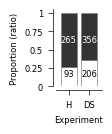

In [9]:
# get metadata
df_hv1 = fr.get_sorted_unit_meta(SORTED_HV1)
df_hv2 = fr.get_sorted_unit_meta(SORTED_HV2)
df_hv3 = fr.get_sorted_unit_meta(SORTED_HV3)
df_hs1 = fr.get_sorted_unit_meta(SORTED_HS1)
df_hs2 = fr.get_sorted_unit_meta(SORTED_HS2)
df_hs3 = fr.get_sorted_unit_meta(SORTED_HS3)

# keep units in cortex
df_hv1 = df_hv1[np.isin(df_hv1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv2 = df_hv2[np.isin(df_hv2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv3 = df_hv3[np.isin(df_hv3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs1 = df_hs1[np.isin(df_hs1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs2 = df_hs2[np.isin(df_hs2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs3 = df_hs3[np.isin(df_hs3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_hv1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

assert all(
    np.isin(np.sort(df_hs1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

# setup
FIGSIZE = (0.6, 1)
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# plot
ax = isolation.plot_unit_isolation_dense_probe(
    ax, df_hv1, df_hv2, df_hv3, df_hs1, df_hs2, df_hs3
)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

# save figures
plt.savefig(
    "figures/1_sorting_quality/yield/assets/fig5B_dense_unit_isolation.svg",
    **savefig_cfg,
)

### Hyp. Testing: the proportion of single-units is the same across experiments

In [24]:
good_hv1 = sum(df_hv1["kslabel"] == "good")
good_hv2 = sum(df_hv2["kslabel"] == "good")
good_hv3 = sum(df_hv3["kslabel"] == "good")
good_h = good_hv1 + good_hv2 + good_hv3
total_h = len(df_hv1["kslabel"]) + len(df_hv2["kslabel"]) + len(df_hv3["kslabel"])

good_hs1 = sum(df_hs1["kslabel"] == "good")
good_hs2 = sum(df_hs2["kslabel"] == "good")
good_hs3 = sum(df_hs3["kslabel"] == "good")

good_ds = good_hs1 + good_hs2 + good_hs3
total_ds = len(df_hs1["kslabel"]) + len(df_hs2["kslabel"]) + len(df_hs3["kslabel"])

good_dense = np.array([good_h, good_ds])
total_dense = np.array([total_h, total_ds])

array([ 93, 206])

In [26]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_dense) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_dense / total_dense * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:", np.round(np.mean(good_dense / total_dense * 100)), "%"
)
print(
    f"\chi^2 ({dof}, {sum(total_dense)})={np.round(result.statistic,1)}, p={result.pvalue}"
)


dense:
expected sorting accuracy: 31.0 %
\chi^2 (1, 920)=1.8, p=0.17729337530535055


### Hyp. testing: single-unit ratio is the same between probe

* we compared the average ratios of (M,NS) and (H, DS)

In [47]:
good_probes_v = np.array([good_npx[0], good_dense[0]])
total_probes_v = np.array([total_npx[0], total_dense[0]])

# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_probes_v) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_probes_v / total_probes_v * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_probes_v / total_probes_v * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_probes_v)})={np.round(result.statistic,1)}, p={result.pvalue}"
)


dense:
expected sorting accuracy: 37.0 %
\chi^2 (1, 558)=6.6, p=0.010454200240941174


In [56]:
good_probes_s = np.array([good_npx[1], good_dense[1]])
total_probes_s = np.array([total_npx[1], total_dense[1]])

# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_probes_s) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_probes_s / total_probes_s * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_probes_s / total_probes_s * 100)),
    "%",
)
print(f"\chi^2 ({dof}, {sum(total_probes_s)})={result.statistic}, p={result.pvalue}")


dense:
expected sorting accuracy: 36.0 %
\chi^2 (1, 1066)=0.004062372471720449, p=0.9491798471326721


420

In [24]:
# evoked testing
import spikeinterface as si
Sref = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/dataset/01_intermediate/sorting/npx_evoked/SortingKS4_10m") # 384 sites
S10 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_DriftCorr") # 202 sites
S7 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/7m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites
S5 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/5m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites

print('10m - total', len(Sref.unit_ids), '- good' ,sum(Sref.get_property('KSLabel')=='good'))
print('10m - total', len(S10.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))
print('7m - total', len(S7.unit_ids), '- <good', sum(S7.get_property('KSLabel')=='good'))
print('5m - total', len(S5.unit_ids), '- good' ,sum(S5.get_property('KSLabel')=='good'))

S10no = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_NoDriftCorr") # 202 sites
print('10m - total', len(S10no.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))

10m - total 3529 - good 408
10m - total 46 - good 17
7m - total 36 - <good 16
5m - total 21 - good 8
10m - total 44 - good 17


In [2]:
# evoked testing
import spikeinterface as si
Sref = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/dataset/01_intermediate/sorting/npx_evoked/SortingKS4_10m") # 384 sites
S10 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_DriftCorr") # 202 sites
S7 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/7m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites
S5 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/5m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites

print('10m - total', len(Sref.unit_ids), '- good' ,sum(Sref.get_property('KSLabel')=='good'))
print('10m - total', len(S10.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))
print('7m - total', len(S7.unit_ids), '- <good', sum(S7.get_property('KSLabel')=='good'))
print('5m - total', len(S5.unit_ids), '- good' ,sum(S5.get_property('KSLabel')=='good'))

S10no = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_NoDriftCorr") # 202 sites
print('10m - total', len(S10no.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))

10m - total 3529 - good 408
10m - total 3540 - good 412
7m - total 36 - <good 16
5m - total 21 - good 8
10m - total 3577 - good 412
